In [281]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   pandas.tseries.offsets import MonthEnd
import statsmodels.api as sm

In [129]:
FIGSIZE = (8, 6)
XRET_KEY_RATES = [2, 5, 7, 10, 15, 20]

In [112]:
yields_data = pd.read_excel('feds200628.xlsx', sheet_name='Yields', skiprows=1, index_col='Date', parse_dates=True )
cpi_data = pd.read_excel('CPILFENS.xls', skiprows=10)

In [332]:
def calc_persistent_cpi(cpi_data):
    v_arr = np.array(list(reversed([0.9868 ** i for i in range(120)])))
    v_sum = np.sum(v_arr)

    cpi_yoy = cpi_data.pct_change(periods=12).dropna()

    cpi_persistent = cpi_yoy.rolling(120).apply(lambda series: (series * v_arr).sum() / v_sum).dropna()
    # cpi_persistent = cpi_yoy.rolling(120).apply(f).dropna()
    cpi_persistent.rename(columns={'CPI': 'CPI_Persistent'}, inplace=True)
    
    return cpi_yoy, cpi_persistent

def calc_excess_return(yields_data):
    log_return = yields_data.apply(lambda x: -int(x.name.replace('SVENY', '')) * (x/100.))
    shifted_log_return = log_return.shift(-12).shift(axis=1)
    xret = (shifted_log_return - log_return).add(log_return['SVENY01'], axis='index')
    xret.drop(columns=['SVENY01'], inplace=True)
    xret.rename(inplace=True, columns=dict((k, v) for k, v in 
                                zip([f'SVENY{x:02d}' for x in range(2, 31)],
                                    [f'xret{x:02d}' for x in range(2, 31)])))
    xret['xret_avg'] = xret.loc[:, [f'xret{x:02d}' for x in XRET_KEY_RATES]].mean(axis=1)
    xret = xret[~xret.isna().any(axis=1)]

    return xret

def prep_prediction_data(yields_data, cpi_data, start_date, end_date):
    
    print(f'Using start date {start_date}')
    yields_os_data = yields_data.reindex(columns=[f'SVENY{x:02d}' for x in range(1, 31)])
    yields_os_data = yields_os_data.resample('M').last().dropna(axis=0, how='all')
    yields_os_data = yields_os_data.loc[start_date:end_date]

    cpi_os_data = cpi_data.set_index('observation_date')
    cpi_os_data = cpi_os_data.resample('M').last()
    _, cpi_os_data = calc_persistent_cpi(cpi_os_data)
    cpi_os_data = cpi_os_data.loc[start_date:end_date]
    return yields_os_data, cpi_os_data

In [287]:
class  CieslakPovalaExcessReturnModel(object):
    
    def __init__(self, cpi_data, yields_data, start_date, end_date):

        # take a copy of the data

        cpi_data = cpi_data.copy()
        yields_data = yields_data.copy()
        cpi_data.set_index('observation_date', inplace=True)
        cpi_data.rename(columns={'CPILFENS':'CPI'}, inplace=True)
        cpi_data = cpi_data.resample('M').last()

        yields_data = yields_data.reindex(columns=[f'SVENY{x:02d}' for x in range(1, 31)])
        # yields_data.index = pd.to_datetime(yields_data.index)
        yields_data.sort_index(inplace=True)
        yields_data = yields_data.resample('M').last().dropna(axis=0, how='all')

        self.cpi_data = self.calc_persistent_cpi(cpi_data)
        self.yields_data = yields_data
        self.start_date, self.end_date = start_date, end_date

    def calc_persistent_cpi(self, cpi_data):
        cpi_yoy, cpi_persistent = calc_persistent_cpi(cpi_data)
        self.cpi_yoy = cpi_yoy
        self.cpi_persistent_rs = cpi_persistent

    def fit(self):
        yields_data = self.yields_data.loc[self.start_date:self.end_date]
        cpi = self.cpi_persistent_rs.loc[self.start_date:self.end_date]

        self.fit_cycles(yields_data, cpi)
        self.calc_excess_return(yields_data)

        xret_n_cycles = pd.merge(self.cycles_df, self.xret, left_index=True, right_index=True)

        self.xret_n_cycles = xret_n_cycles.loc[self.start_date:self.end_date]
        self.fit_xr_mf_model()
        self.fit_xr_sf_model()

    def fit_xr_mf_model(self):
        xr_model = {}

        for xr in range(2, 31):
            y = self.xret_n_cycles[f'xret{xr:02d}']
            x = self.xret_n_cycles[[f'cycle{cyc:02d}' for cyc in [1] + XRET_KEY_RATES]]
            x = sm.add_constant(x)
            model = sm.OLS(y, x, missing='drop')
            res = model.fit()
            xr_model[xr] = res 

        self.xr_model = xr_model

    def fit_xr_sf_model(self):
        y = self.xret_n_cycles['xret_avg']
        x = self.xret_n_cycles[['cycle01', 'cycle_avg']]
        x = sm.add_constant(x)
        model = sm.OLS(y, x, missing='drop')
        res = model.fit()
        self.xr_model['cf'] = res

    def calc_excess_return(self, yields_data):
        self.xret = calc_excess_return(yields_data)

    def plot_xret(self):
        data = self.xret.loc[:, [f'xret{x:02d}' for x in XRET_KEY_RATES] ]
        data.plot(figsize=FIGSIZE, title=f'Excess Returns for {XRET_KEY_RATES} yrs')

    def plot_cpi(self):
        cpi_data_full = pd.merge(self.cpi_yoy, self.cpi_persistent_rs, how='right', on='observation_date')
        cpi_data_full.plot(figsize=FIGSIZE)
        
    def fit_cycles(self, yields_data, cpi):

        self.cycle_models = {}
        for tenor in range(1, 31):
            col_name = f'SVENY{tenor:02d}'
            y = yields_data[col_name]
            x = cpi
            x = sm.add_constant(x)
            model = sm.OLS(y, x, missing='drop')
            res = model.fit()
            self.cycle_models[tenor] = res

        cycles_df = pd.concat([c.resid for k, c in self.cycle_models.items()], axis=1)
        cycles_df.columns = [f'cycle{x:02d}' for x in self.cycle_models.keys()]
        cycles_df = cycles_df.loc[self.start_date: self.end_date]
        cycles_df['cycle_avg'] = cycles_df.loc[:, [f'cycle{x:02d}' for x in XRET_KEY_RATES]].sum(axis=1)

        self.cycles_df = cycles_df

    def predict(self, cpi, yields):
        # make prediction using single factor model, then mutlti factor model

        yield_predictions = {}
        # 1. calculate each of the maturity specific cycles
        key_yields = yields.loc[:, [f'SVENY{x:02d}' for x in [1] + XRET_KEY_RATES] ]
        for tenor in [1] + XRET_KEY_RATES:
            model = self.cycle_models[tenor]
            res = model.predict(exog=sm.add_constant(cpi))
            yield_predictions[f'SVENY{tenor:02d}'] = res
        
        cycle_df = key_yields - pd.DataFrame(yield_predictions) 
        
        xret_predictions = {}
        for tenor in XRET_KEY_RATES:
            xr_model = self.xr_model[tenor]
            res = xr_model.predict(exog=sm.add_constant(cycle_df))
            xret_predictions[f'pxret{tenor:02d}'] = res

        xret_df = pd.DataFrame(xret_predictions)
        return xret_df


In [288]:
start_date, end_date = pd.Timestamp('1995-01-31'), pd.Timestamp('2019-10-31')
cpmodel = CieslakPovalaExcessReturnModel(cpi_data, yields_data, start_date, end_date)
cpmodel.fit()

In [290]:
os_start_date = end_date + MonthEnd(1)
os_end_date = pd.Timestamp('2022-03-31')
yields_os_data, cpi_os_data = prep_prediction_data(yields_data, cpi_data, os_start_date, os_end_date)

Using start date 2019-11-30 00:00:00


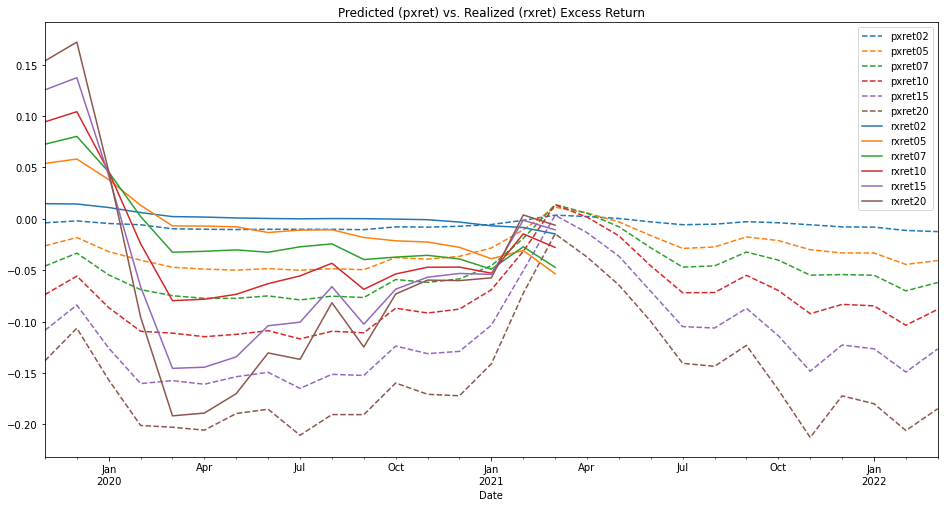

In [334]:
xret_df = cpmodel.predict(cpi_os_data, yields_os_data)
ax = xret_df.plot(figsize=FIGSIZE, style=dict((k, '--') for k in xret_df.columns), 
                  title='Predicted (pxret) vs. Realized (rxret) Excess Return')


realized_xret = calc_excess_return(yields_os_data)
realized_xret.rename(inplace=True, columns=dict((k, v) for k, v in 
    zip(
        [f'xret{x:02d}' for x in XRET_KEY_RATES], 
        [f'rxret{x:02d}' for x in XRET_KEY_RATES]
        )
))

color_dict = dict( (l._label.replace('p', 'r'), f'{l.get_color()}' ) for l in ax.lines )
rxret = realized_xret.loc[:,[f'rxret{x:02d}' for x in XRET_KEY_RATES]]
_ = rxret.plot(figsize=(16, 8), ax=ax, color=color_dict)

<AxesSubplot:xlabel='Date'>

In [304]:
l = ax.lines[0]

In [309]:
l.get_color()

'#1f77b4'

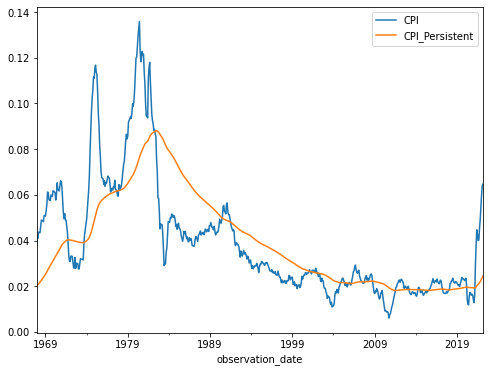

In [159]:
cpmodel.plot_cpi()

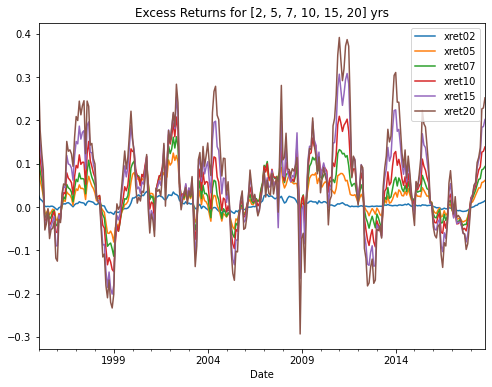

In [160]:
cpmodel.plot_xret()

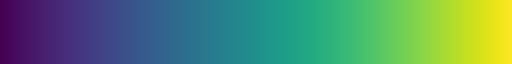

In [298]:
plt.get_cmap()